cannon
---

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import tensorflow as tf
import keras

In [2]:
# a spherical target gets a position somewhere in 3d. The cannon at (0,0,0) fires a shell at a given speed,\
# rotation, and angle.

In [185]:
pi = np.pi

#simulates a ballistic trajectory and returns the smallest distance to the target position
def simulate_trajectory_distance(speed, azi, pitch, target, origin = np.array([0.,0.,0.]), timestep = 0.1, g = -10.):
    #get cartesian velocity from spherical coordinates
    velocity = speed*np.array([
        np.cos(azi)*np.cos(pitch),
        np.sin(azi)*np.cos(pitch),
        np.sin(pitch)
    ])
#     print(f'Starting velocity {velocity}.')
    #make acceleration vector
    acc = np.array([0.,0., g])
    #record origin and first position after 1 timestep
    history = [origin, origin+ velocity*timestep + (1/2)*acc*timestep**2]
    position = history[-1]
#     print(history)
    #record distances
    distances = [np.linalg.norm(target - origin), np.linalg.norm(target - position)]
    #while the ball is above the ground, timestep to change position
    while position[2] >= 0:
#         print(history[-1])
        position = 2*history[-1] - history[-2] + acc*(timestep**2)
        distances.append(np.linalg.norm(target - position))
        history.append(position)
    return np.array(distances).min(), np.array(history)
    

In [186]:
distance, history = simulate_trajectory_distance(100, 0, pi/3, np.array([100,200,300]))

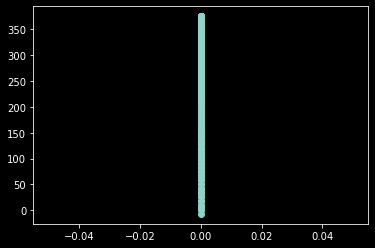

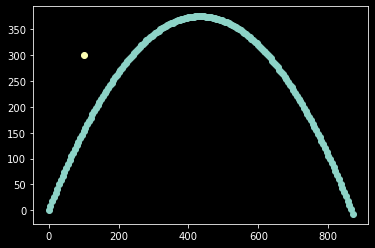

In [187]:
plt.scatter(history[:,1],history[:,2])
plt.show()
plt.scatter(history[:,0],history[:,2])
plt.scatter([[100]],[[300]])
plt.show()

In [249]:
# %%time

seed = 2022
rng = np.random.default_rng(seed)

eps = np.finfo(np.float32).eps.item()

gamma = 0.99
rounds_per_load = 100
minimum_acceptable_score = 500
scores_to_average = 10
max_speed = 100 #m/s
field_size = 2000 #m

hit_distance = 10 #10 cm radius of target
miss_penalty = 500 #add this number of meters to distance as a penalty for missing.

num_inputs = 3 #targetx,y,z
num_outputs = 3 #speed*max_speed, azimuth/(2pi), pitch/(pi)
num_hidden = 32

#make model
inputs = keras.layers.Input(shape = (num_inputs,))
dense_1 = keras.layers.Dense(num_hidden, activation = 'relu')(inputs)
outputs = keras.layers.Dense(num_outputs, activation = 'softmax')(dense_1)
model = keras.Model(inputs = inputs, outputs = outputs)

#make optimizer
optimizer = keras.optimizers.Adam(learning_rate = 0.01)

avg_recent_score = 0
all_scores = [0]
#train until performance is good enough
while avg_recent_score < minimum_acceptable_score:
    with tf.GradientTape() as tape:
        command_history = []
        loss_history = []
        #reload the cannon and shoot all the shots
        for shot in range(rounds_per_load):
            #place a random target in the block, and make sure it's above the ground.
            target = field_size*rng.random(3) - field_size/2
            target[2] = abs(target[2])
            target = tf.convert_to_tensor(target)
            target = tf.expand_dims(target, 0)
            
            command = model(target)
            speed, azi, pitch = command[0]
#             command_history.append([speed, azi, pitch])
            speed = float(speed*max_speed)
            azi = azi*float(2*pi)
            pitch =  pitch*float(pi)
            
            loss, _ = simulate_trajectory_distance(speed, azi, pitch, target)
            if distance < hit_distance:
                loss += miss_penalty
            loss_history.append(loss)
            
            
        total_loss = tf.convert_to_tensor(sum(loss_history))
        grads = tape.gradient(total_loss, model.trainable_variables )
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        all_scores.append(total_loss)
#         command_history.clear()
        loss_history.clear()
        
        avg_recent_score = np.mean(all_scores[-scores_to_average:])

ValueError: No gradients provided for any variable: (['dense_86/kernel:0', 'dense_86/bias:0', 'dense_87/kernel:0', 'dense_87/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'dense_86/kernel:0' shape=(3, 32) dtype=float32, numpy=
array([[-0.21733852,  0.2541562 ,  0.17779991,  0.22525188,  0.40890196,
         0.05859524,  0.18464962,  0.35895804,  0.2853019 , -0.2548804 ,
         0.28599587, -0.17051381,  0.04978982, -0.00213066,  0.04482257,
        -0.30218378, -0.00358889, -0.11789927,  0.3059071 ,  0.04675886,
        -0.1368508 ,  0.40501276,  0.32640037, -0.37838566,  0.35627893,
        -0.20254543,  0.06897709, -0.37711364,  0.01299351, -0.04002395,
        -0.0473398 , -0.32531372],
       [ 0.4048212 ,  0.22514084, -0.2284219 , -0.39909947, -0.25559735,
         0.07832092, -0.4031594 , -0.21953551, -0.23610348, -0.33186817,
        -0.15193748, -0.17786449,  0.1039634 , -0.32341167,  0.08672175,
         0.40290263, -0.28246188,  0.16680321,  0.35083845,  0.14492497,
        -0.12159899,  0.06081891, -0.1130513 , -0.24821903, -0.20604555,
         0.2148734 ,  0.2390438 ,  0.38206556, -0.13626239, -0.20678315,
        -0.05148008, -0.26111007],
       [ 0.39813444,  0.18156311, -0.06606796, -0.12591302, -0.29698545,
        -0.12778753,  0.07725963, -0.17501006, -0.4031289 ,  0.10402009,
         0.4059461 ,  0.2571285 , -0.369912  ,  0.40697363, -0.02346972,
        -0.33045408, -0.3528234 ,  0.17690274,  0.27959767, -0.39001495,
        -0.32946306, -0.1842922 ,  0.15374753,  0.32048753,  0.01800516,
        -0.01193875,  0.03431293, -0.02511221,  0.20337066,  0.12528798,
         0.36924598, -0.33230546]], dtype=float32)>), (None, <tf.Variable 'dense_86/bias:0' shape=(32,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>), (None, <tf.Variable 'dense_87/kernel:0' shape=(32, 3) dtype=float32, numpy=
array([[-0.19759212, -0.30364525, -0.0273267 ],
       [-0.3966775 , -0.318519  ,  0.30712405],
       [-0.18232165,  0.34636095, -0.30602813],
       [-0.29644084, -0.16040373,  0.2908145 ],
       [-0.24874489, -0.2808916 ,  0.12058935],
       [ 0.18837121,  0.18436083,  0.3621563 ],
       [ 0.12460336,  0.24734548,  0.38942733],
       [-0.2776055 , -0.0233559 ,  0.05900058],
       [-0.1433425 , -0.2470918 ,  0.18549195],
       [ 0.40037075, -0.31239915,  0.35859093],
       [-0.3956722 , -0.04054606, -0.2543211 ],
       [-0.29392588,  0.01444542,  0.15603164],
       [-0.07901102,  0.37789318, -0.19146362],
       [-0.28275   , -0.25518996,  0.32341185],
       [ 0.3008062 ,  0.13017651, -0.02003029],
       [-0.24036193, -0.10832959,  0.09496942],
       [-0.10629308, -0.1557765 ,  0.01987493],
       [ 0.36326447,  0.03238177, -0.12495244],
       [ 0.17133728, -0.11556655,  0.33808312],
       [ 0.10278204, -0.22673339, -0.37095207],
       [ 0.21516523, -0.01251879,  0.08764592],
       [ 0.04212293,  0.12633947,  0.11440608],
       [-0.14020455,  0.37512758, -0.09271589],
       [-0.0669786 , -0.05558693,  0.04935527],
       [-0.36460146, -0.37923393,  0.19654182],
       [-0.01366913, -0.04405418,  0.15991697],
       [-0.1569964 ,  0.00629464, -0.33618733],
       [ 0.06981811,  0.39196357,  0.18468043],
       [-0.3307767 , -0.4097959 , -0.16378659],
       [-0.39012304,  0.10090032, -0.34553522],
       [-0.05350977,  0.26424715,  0.15668479],
       [-0.07886177,  0.1830003 , -0.08306277]], dtype=float32)>), (None, <tf.Variable 'dense_87/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>)).

In [244]:
type(total_loss)

numpy.float64

In [182]:
speed, azi, pitch = command[0]

In [242]:
total_loss

<tf.Tensor: shape=(), dtype=float32, numpy=95235.98>

In [234]:
loss_history

[983.75146226268,
 1065.9363398303403,
 1212.510358480098,
 1439.4009814129497,
 635.48597456252,
 1267.6018317368687,
 1403.5409452379367,
 1283.7666638192338,
 1066.2258794515692,
 1357.0035795830463,
 1154.9631787021635,
 1092.469264517021,
 1354.1521991539105,
 605.0271897423004,
 920.7112263008795,
 1075.9242523689443,
 926.5667688220723,
 643.8224353162451,
 886.386076371366,
 530.0600294700126,
 911.3295409470063,
 817.0571804996558,
 837.2949449581835,
 1200.1008524135343,
 847.5867385148208,
 582.663757987239,
 1261.2371710910652,
 1470.7814493520455,
 403.7198826918457,
 880.5269288243502,
 1046.263820855672,
 997.7586406063555,
 547.9875428350715,
 1066.561013584888,
 634.4180967495117,
 843.7595846342756,
 937.9964579392506,
 1205.8835829260604,
 1219.4467892136463,
 1166.8052749189821,
 424.42383720251183,
 1140.5674041797145,
 1235.9172944449176,
 1128.8288705117186,
 884.7910778720774,
 1369.8383763934326,
 858.9113990929427,
 1029.5272696653492,
 1019.5576212424015,
 81

In [179]:
simulate_trajectory_distance(speed, azi, pitch, [0,0,0])

(0.0,
 array([[ 0.  ,  0.  ,  0.  ],
        [ 0.1 ,  0.  , -0.05]]))

In [206]:
speed

<tf.Tensor: shape=(), dtype=float32, numpy=100.0>

In [231]:
with tf.GradientTape() as ya:
    hey = ya.gradient(tf.convert_to_tensor([234234.]), model.trainable_variables)

In [232]:
hey

[None, None, None, None]